In [108]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
import os
import gc
from transformers import pipeline
import requests
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
gc.collect()

9211

# functions

In [109]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

#MADGRAD 
exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)

Global seed set to 42


# load data and split data (train,val)

In [110]:

from sklearn.model_selection import train_test_split
df = pd.read_csv('../data/preprocess_for_SQUAD_產品.csv',index_col=0)[['string_X_train','Y_label','string_Y_1','string_Y_2']].dropna(axis=0)
print(df.shape)
train_df, val_df = train_test_split(df,test_size=0.2,random_state=random_state)
display(train_df.head(3)),display(val_df.head(3))

(1970, 4)


,string_X_train,Y_label,string_Y_1,string_Y_2
6662,CIF ANY CHINESE PORT1ABS RESIN GRADE NO AF3537...,AF3537,40,46
3339,TERMS OF PRICE CFR GUAYAQUIL ECUADOR COUNTRY ...,MALEIC ANHYDRIDE,64,80
4540,54000 KGS PHTHALIC ANHYDRIDE AS PER APPLICAN...,PHTHALIC ANHYDRIDE,11,29


,string_X_train,Y_label,string_Y_1,string_Y_2
4198,COPPER CLAD LAMINATES 7800 SHEETSAS PER PUR...,COPPER CLAD LAMINATES,1,22
4229,CIF JAPAN MAIN PORT OR AIRPORT COPPER FOIL,COPPER FOIL,31,42
7863,COPPER CLAD LAMINATES 4420 SHT USD 1065604OR...,COPPER CLAD LAMINATES,1,22


(None, None)

# load model and tokenizer

In [111]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

# Data preprocessing

In [112]:
def preprocessing(df):
    contexts = df['string_X_train'].values.tolist()
    questions = [ 'What is the product name ?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

In [113]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    return encodings

In [114]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [115]:
def df2Dataloader(df):
    contexts ,questions ,answers = preprocessing(df)
    encodings = tokenizer(contexts, questions, truncation=True, padding=True)
    encodings = add_token_positions(encodings, answers)
    dataset = SquadDataset(encodings)
    return DataLoader(dataset,batch_size=8)

In [116]:
train_loader = df2Dataloader(train_df)
val_loader = df2Dataloader(val_df)

# train model

In [117]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()
optimizer = MADGRAD(model.parameters() ,lr = 5e-5)

In [118]:
def step(model,batch,optimizer,device,mode='train'):
    model = model.to(device)
    # change mode
    if mode == 'train':
        model.train()
    if mode == 'val':
        model.eval()
    # forward pass
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # update model if mode == train
    if mode == 'train': 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()

In [119]:
def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    for epoch in tqdm(range(max_epochs)):        
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += step(model,batch,optimizer,device,mode='train')
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += step(model,batch,optimizer,device,mode='val')
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')
    return best_model.eval() ,history

In [120]:
best_model ,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=3)


epoch:0 train_loss:0.7224985809797155 val_loss:0.38872667546479067
save best_model now_val_best_loss is:0.38872667546479067



epoch:1 train_loss:0.3427637981616759 val_loss:0.31082048506609034
save best_model now_val_best_loss is:0.31082048506609034



epoch:2 train_loss:0.15959212697070682 val_loss:0.1967456847719126
save best_model now_val_best_loss is:0.1967456847719126



# save model

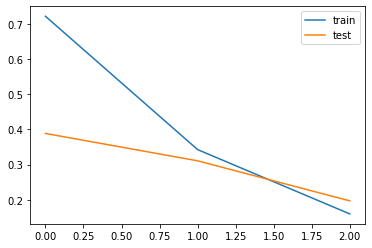

In [121]:
import matplotlib.pyplot as plt
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='test')
plt.legend()
plt.show()

In [122]:
model_path = '../models/Product_Data_SQuAD_model_product.pt'
torch.save(best_model.state_dict(),model_path)

# load trained model

In [123]:
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model.load_state_dict(torch.load(model_path))
model.eval()
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

# test

In [124]:
def test_model(nlp,df):
    table = pd.DataFrame()
    for i in tqdm(df.index):
        sample = df.loc[[i]]
        string_X_train = sample['string_X_train'].values[0]
        Y_label = sample['Y_label'].values[0]  
        QA_input = {
            'question': 'What is the product name?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({'Y_label':Y_label,'predict':predict},index=[i])
        if Y_label == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
    return table

In [125]:
table = test_model(nlp,val_df)
display(table)

,Y_label,predict,是否全對
4198,COPPER CLAD LAMINATES,COPPER CLAD LAMINATES,Yes
4229,COPPER FOIL,COPPER FOIL,Yes
7863,COPPER CLAD LAMINATES,COPPER CLAD LAMINATES,Yes
6145,GLASS FABRICS,GLASS FABRICS,Yes
5814,FIBER GRADE,FIBER GRADE,Yes
...,...,...,...
858,NPEL 128,EPOXY RESIN1,No
20126,POLYESTER STAPLE FIBER,POLYESTER STAPLE FIBER,Yes
6731,POLYESTER FILM B GRADE,POLYESTER FILM B GRADE,Yes
5624,TAISOX 9001,TAISOX 9001,Yes


In [126]:
display(table[table['是否全對']=='Yes'])

,Y_label,predict,是否全對
4198,COPPER CLAD LAMINATES,COPPER CLAD LAMINATES,Yes
4229,COPPER FOIL,COPPER FOIL,Yes
7863,COPPER CLAD LAMINATES,COPPER CLAD LAMINATES,Yes
6145,GLASS FABRICS,GLASS FABRICS,Yes
5814,FIBER GRADE,FIBER GRADE,Yes
...,...,...,...
6735,COPPER FOIL,COPPER FOIL,Yes
20126,POLYESTER STAPLE FIBER,POLYESTER STAPLE FIBER,Yes
6731,POLYESTER FILM B GRADE,POLYESTER FILM B GRADE,Yes
5624,TAISOX 9001,TAISOX 9001,Yes


In [127]:
display(table[table['是否全對']=='No'])

,Y_label,predict,是否全對
6964,TAISOX 8010,TAISOX 9001,No
2853,COPPER CLAD LAMINATES,GLASS EPOXY COPPER CLAD LAMINATES,No
2364,BOPP FILM PL50,BOPP FILM,No
7183,AX4100,AG15A1,No
17527,POLYESTER TEXTURED YARN,YARN,No
3081,AE8000,AG10NP,No
20265,PVC SUSPENSION RESIN S 70,S 70,No
3753,MIN 99 PCT,CAUSTIC SODA MICROPEARLS,No
4771,COPPER CLAD LAMINATES,GLASS EPOXY PREPREG4639,No
6488,ANC100,AF3535,No


# claculate acc and jaccard

In [128]:
def get_acc(df,t=1):
    correct = []
    correct_label = []
    for i in df.index:
        jac = get_jaccard_sim(df.loc[i,'Y_label'],df.loc[i,'predict'])
        if jac >= t:
            correct.append('yes')
        else:
            correct.append('no')
    a = pd.Series(correct)
    return a.value_counts()['yes']/len(a)

In [129]:
print('jaccard_avg_score:',np.mean([ get_jaccard_sim(table['Y_label'].loc[i],table['predict'].loc[i]) for i in table.index]))
print('acc:',get_acc(table,1))
print('放水acc:',get_acc(table,0.75))
print('放水acc:',get_acc(table,0.5))
print('放水acc:',get_acc(table,0.25))

jaccard_avg_score: 0.9281323019901702
acc: 0.9060913705583756
放水acc: 0.9060913705583756
放水acc: 0.9263959390862944
放水acc: 0.949238578680203
